In [ ]:
%tensorflow_version 1.15.2

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


# New Section

In [ ]:
!dir

aryan1	drive  sample_data


In [ ]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

TPU address is grpc://10.7.86.178:8470


In [ ]:
from google.colab import auth
auth.authenticate_user()


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
with tf.compat.v1.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

    # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

NameError: ignored

In [ ]:
import sys

!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo
if not 'bert_repo' in sys.path:
  sys.path += ['bert_repo']

# import python modules defined by BERT
import modeling
import optimization
import run_classifier
import run_classifier_with_tfhub
import tokenization

# import tfhub
import tensorflow_hub as hub

Cloning into 'bert_repo'...
remote: Enumerating objects: 340, done.
remote: Total 340 (delta 0), reused 0 (delta 0), pack-reused 340
Receiving objects: 100% (340/340), 328.28 KiB | 4.10 MiB/s, done.
Resolving deltas: 100% (182/182), done.



In [ ]:
TASK = 'MRPC' #@param {type:"string"}
assert TASK in ('MRPC', 'CoLA'), 'Only (MRPC, CoLA) are demonstrated here.'


In [ ]:
# Download glue data.
! test -d download_glue_repo || git clone https://gist.github.com/60c2bdb54d156a41194446737ce03e2e.git download_glue_repo
!python download_glue_repo/download_glue_data.py --data_dir='glue_data' --tasks=$TASK


Cloning into 'download_glue_repo'...
remote: Enumerating objects: 24, done.
remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 24
Unpacking objects: 100% (24/24), done.
Processing MRPC...
Traceback (most recent call last):
  File "download_glue_repo/download_glue_data.py", line 150, in <module>
    sys.exit(main(sys.argv[1:]))
  File "download_glue_repo/download_glue_data.py", line 142, in main
    format_mrpc(args.data_dir, args.path_to_mrpc)
  File "download_glue_repo/download_glue_data.py", line 65, in format_mrpc
    URLLIB.urlretrieve(MRPC_TRAIN, mrpc_train_file)
NameError: name 'URLLIB' is not defined


In [ ]:
TASK_DATA_DIR = 'glue_data/' + TASK
print('***** Task data directory: {} *****'.format(TASK_DATA_DIR))
!ls $TASK_DATA_DIR

BUCKET = 'bert-bucket8988' #@param {type:"string"}
assert BUCKET, 'Must specify an existing GCS bucket name'
OUTPUT_DIR = 'gs://{}/bert-tfhub/models/{}'.format(BUCKET, TASK)
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

# Available pretrained model checkpoints:
#   uncased_L-12_H-768_A-12: uncased BERT base model
#   uncased_L-24_H-1024_A-16: uncased BERT large model
#   cased_L-12_H-768_A-12: cased BERT large model
BERT_MODEL = 'uncased_L-12_H-768_A-12' #@param {type:"string"}
BERT_MODEL_HUB = 'https://tfhub.dev/google/bert_' + BERT_MODEL + '/1'

***** Task data directory: glue_data/MRPC *****
***** Model output directory: gs://bert-bucket8988/bert-tfhub/models/MRPC *****


In [ ]:
tokenizer = run_classifier_with_tfhub.create_tokenizer_from_hub_module(BERT_MODEL_HUB)
tokenizer.tokenize("This here's an example of using the BERT tokenizer")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


['this',
 'here',
 "'",
 's',
 'an',
 'example',
 'of',
 'using',
 'the',
 'bert',
 'token',
 '##izer']

In [ ]:
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 8
PREDICT_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
MAX_SEQ_LENGTH = 128
# Warmup is a period of time where hte learning rate
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 1000
SAVE_SUMMARY_STEPS = 500

processors = {
  "cola": run_classifier.ColaProcessor,
  "mnli": run_classifier.MnliProcessor,
  "mrpc": run_classifier.MrpcProcessor,
}
processor = processors[TASK.lower()]()
label_list = processor.get_labels()

# Compute number of train and warmup steps from batch size
train_examples = processor.get_train_examples(TASK_DATA_DIR)
num_train_steps = int(len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Setup TPU related config
tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
NUM_TPU_CORES = 8
ITERATIONS_PER_LOOP = 1000

def get_run_config(output_dir):
  return tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=output_dir,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))

NotFoundError: ignored

In [ ]:
import pandas as pd

In [ ]:
pip install transformers

     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 43.0 MB/s 
     |████████████████████████████████| 895 kB 48.3 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 
     |████████████████████████████████| 596 kB 57.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertForQuestionAnswering

In [ ]:
model= BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

In [ ]:
from transformers import BertTokenizer

In [ ]:
tokenizer=BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
question="Who leads the chennai super kings in IPL 2021?"

In [ ]:
answer_text="IPL 2021 held in dubai. Chennai super kings won the title. M.S.Dhoni was the captain of the Chennai super kings."

In [ ]:
input_ids=tokenizer.encode(question,answer_text)

In [ ]:
print("The input has total of {0} tokens.".format(len(input_ids)))

The input has total of 43 tokens.


In [ ]:
tokens=tokenizer.convert_ids_to_tokens(input_ids)

In [ ]:
for token,id in zip(tokens,input_ids):
  if id == tokenizer.sep_token_id:
    print('')
  print('{:<12}{:>6}'.format(token,id))
  if id == tokenizer.sep_token_id:
    print('')

[CLS]          101
who           2040
leads         5260
the           1996
chennai      12249
super         3565
kings         5465
in            1999
ip           12997
##l           2140
2021         25682
?             1029

[SEP]          102

ip           12997
##l           2140
2021         25682
held          2218
in            1999
dubai        11558
.             1012
chennai      12249
super         3565
kings         5465
won           2180
the           1996
title         2516
.             1012
m             1049
.             1012
s             1055
.             1012
dh           28144
##oni        10698
was           2001
the           1996
captain       2952
of            1997
the           1996
chennai      12249
super         3565
kings         5465
.             1012

[SEP]          102



In [ ]:
sep_index=input_ids.index(tokenizer.sep_token_id)

In [ ]:
num_seq_a=sep_index+1

In [ ]:
num_seq_b = len(input_ids) - num_seq_a

In [ ]:
segment_ids=[0]*num_seq_a + [1] * num_seq_b

In [ ]:
assert len(segment_ids) == len(input_ids)


In [ ]:
import torch

In [ ]:
start_scores, end_scores = model(torch.tensor([input_ids]), token_type_ids = torch.tensor ([segment_ids]),return_dict=False)

In [ ]:
print(end_scores)

tensor([[-1.2046, -6.0961, -7.4613, -7.4752, -6.6255, -6.9759, -5.7766, -7.5600,
         -6.0550, -6.1874, -5.4336, -6.8355, -1.2045, -5.1881, -3.6273, -1.7752,
         -5.0137, -6.8907, -2.4476, -1.2052, -2.4640, -5.0458, -1.1529, -4.1907,
         -5.7987, -1.5215, -1.2046, -1.3169, -4.9004, -1.2244, -2.3697, -1.3324,
          5.5976, -2.8141, -5.4339,  0.5763, -4.7219, -6.1163, -3.5132, -5.1742,
          1.9517,  1.6363, -1.2047]], grad_fn=<CopyBackwards>)


In [ ]:
answer_start = torch.argmax(start_scores)

In [ ]:
answer_end = torch.argmax(end_scores)

In [ ]:
answer = ' '.join(tokens[answer_start:answer_end])

In [ ]:
print('Answer: "' +answer+ '"')

Answer: "m . s . dh"


In [ ]:
answer = tokens[answer_start]
for i in range(answer_start+1,answer_end+1):
  if tokens[i][0:2]=="##":
    answer += tokens[i][2:]
  else:
    answer += ' ' + tokens[i]
print('Answer: "' +answer+ '".')

Answer: "m . s . dhoni".


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

plt.rcParams["figure.figsize"]= (16,8)



In [ ]:
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()


token_labels = []
for (i,token) in enumerate (tokens):
  token_labels.append('{:}-{:>2}'.format(token,i))

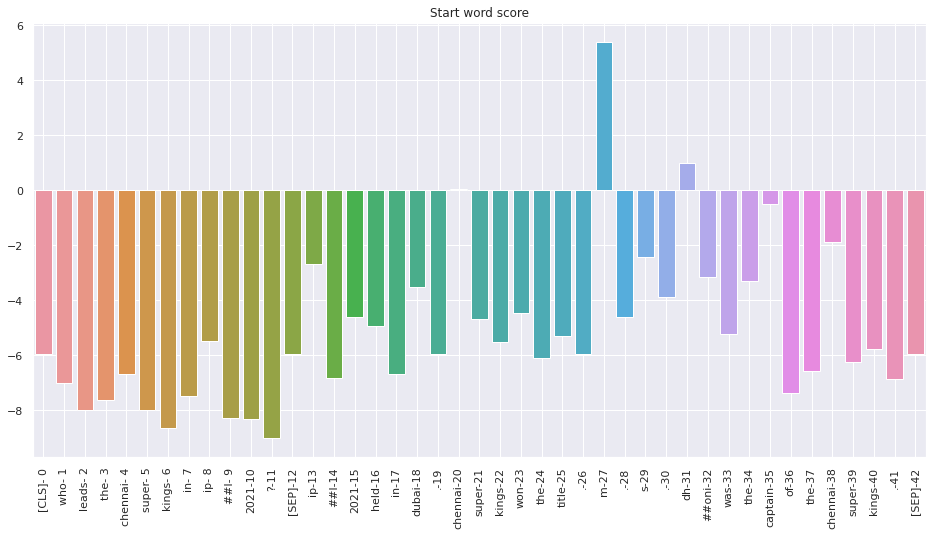

In [ ]:
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

ax.grid(True)

plt.title('Start word score')

plt.show()

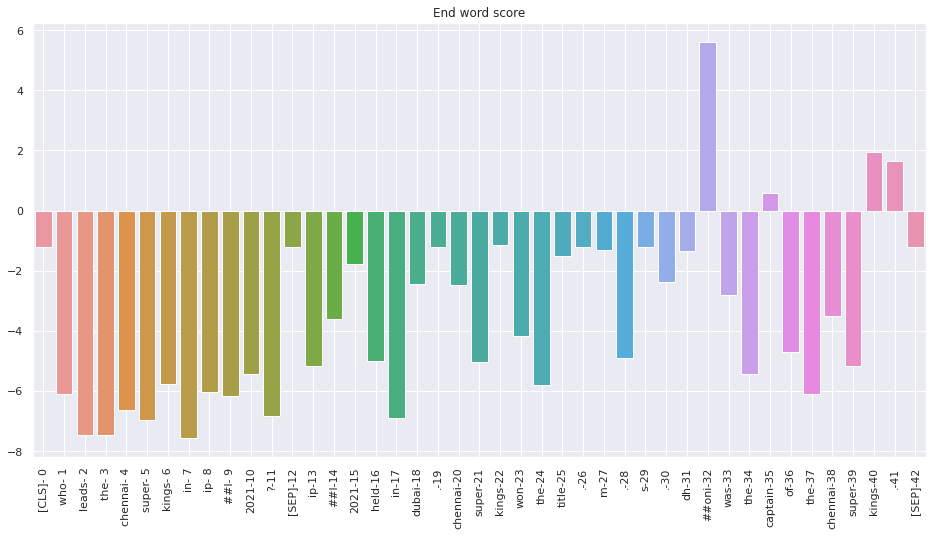

In [ ]:
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

ax.grid(True)

plt.title('End word score')

plt.show()

In [ ]:
def print_graph(start_scores, end_scores, tokens):
  import matplotlib.pyplot as plt
  import seaborn as sns

  sns.set(style='darkgrid')

  plt.rcParams["figure.figsize"]= (16,8)

  s_scores = start_scores.detach().numpy().flatten()
  e_scores = end_scores.detach().numpy().flatten()


  token_labels = []
  for (i,token) in enumerate (tokens):
    token_labels.append('{:}-{:>2}'.format(token,i))


  ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

  ax.grid(True)

  plt.title('Start word score')

  plt.show()
  ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

  ax.grid(True)

  plt.title('End word score')

  plt.show()



In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 30.9 MB/s 
     |████████████████████████████████| 56 kB 4.1 MB/s 
     |████████████████████████████████| 895 kB 47.9 MB/s 
     |████████████████████████████████| 3.3 MB 34.8 MB/s 
     |████████████████████████████████| 596 kB 61.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
def question_answer():
  #import BertForQuestionAnswering, BertTokenizer, torch
  from transformers import BertForQuestionAnswering
  from transformers import BertTokenizer
  import torch

  # create model using a pretraind model (squad)
  model= BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
  # create BertTokenizer from finetuned-squad model
  tokenizer=BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


  #Get the knowledge Base to search on
  files=[]
  Fl=''
  print("Enter file names as knowledge base to search for answers:")
  while Fl != '0':
    Fl=input("Enter the file name or enter 0 to stop:")
    if Fl != '0':
      Fle=Fl + '.txt'
      files.append(Fle)
  file_text=[]
  lines = []

  try:
    for x in range (0, len(files)):
      with open(files[x]) as f:
        lines = f.readlines()
      text=''
      for x in range(0,len(lines)):
        text +=lines[x]
      file_text.append(text)
  except:
    print("Please enter correct text file name without extension...")

  # Get the question from the user
  question = input("Enter your question:")




  # Do this for all files, encode the question and answer and tokenize them
  for x in file_text:
    answer_text=x
    input_ids=tokenizer.encode(question,answer_text)
    tokens=tokenizer.convert_ids_to_tokens(input_ids)


    sep_index=input_ids.index(tokenizer.sep_token_id)
    num_seq_a=sep_index+1
    num_seq_b = len(input_ids) - num_seq_a
    segment_ids=[0]*num_seq_a + [1] * num_seq_b
    assert len(segment_ids) == len(input_ids)


    start_scores, end_scores = model(torch.tensor([input_ids]), token_type_ids = torch.tensor ([segment_ids]),return_dict=False)
    #print(outputs)




    print("\n\n")
    #print("start_score:{0}".format(max(start_scores[0])))
    #print("end_score:{0}".format(max(end_scores[0])))
    a=max(start_scores[0])
    b=max(end_scores[0])
    if (a+b)<0:
      score=0
    else:
      score=((a+b)/2)
    print("Out of 10, accuracy score:{0}".format(score))
    answer_start = torch.argmax(start_scores)
    #print(answer_start)
    answer_end = torch.argmax(end_scores)
    #print(answer_end)


	  #print the Answer

    answer = tokens[answer_start]
    for i in range(answer_start+1,answer_end+1):
      if tokens[i][0:2]=="##":
        answer += tokens[i][2:]
      else:
        answer += ' ' + tokens[i]
    print('Answer: "' +answer+ '".')

In [ ]:
!dir


drive  sample_data  untitled


In [ ]:
question_answer()

Enter file names as knowledge base to search for answers:
Enter the file name or enter 0 to stop:Agni1
Enter the file name or enter 0 to stop:Agni2
Enter the file name or enter 0 to stop:Agni3
Enter the file name or enter 0 to stop:0
Enter your question:what is the range of agni?



Out of 10, accuracy score:5.941425323486328
Answer: "5 , 000 kilometres".



Out of 10, accuracy score:0
Answer: "[SEP]".



Out of 10, accuracy score:0
Answer: "6 , 200 km per hour".


In [ ]:
question_answer()

Enter file names as knowledge base to search for answers:
Enter the file name or enter 0 to stop:Agni1
Enter the file name or enter 0 to stop:Agni2
Enter the file name or enter 0 to stop:Agni3
Enter the file name or enter 0 to stop:0
Enter your question:What is Agni?



Out of 10, accuracy score:5.789709091186523
Answer: "surface - to - surface ballistic missile".



Out of 10, accuracy score:0
Answer: "multiple independently targetable reentry vehicles".



Out of 10, accuracy score:3.587531566619873
Answer: "nuclear threat initiative".


In [ ]:
question_answer()

Enter file names as knowledge base to search for answers:
Enter the file name or enter 0 to stop:Agni1
Enter the file name or enter 0 to stop:Agni3
Enter the file name or enter 0 to stop:Agni2
Enter the file name or enter 0 to stop:0
Enter your question:Why Agni needed?



Out of 10, accuracy score:5.1017374992370605
Answer: "credible minimum deterrence".



Out of 10, accuracy score:3.962021827697754
Answer: "maintaining strategic stability".



Out of 10, accuracy score:2.241825819015503
Answer: "covid - 19 pandemic".


In [ ]:
question_answer()

Enter file names as knowledge base to search for answers:
Enter the file name or enter 0 to stop:Agni3
Enter the file name or enter 0 to stop:Agni2
Enter the file name or enter 0 to stop:Agni1
Enter the file name or enter 0 to stop:0
Enter your question:What is a bellistic missile?



Out of 10, accuracy score:2.2695870399475098
Answer: "long - range ballistic missiles".



Out of 10, accuracy score:2.6977150440216064
Answer: "multiple independently targetable reentry vehicles ( mirv )".



Out of 10, accuracy score:7.518309116363525
Answer: "agni - 5".


In [ ]:
question_answer()

Enter file names as knowledge base to search for answers:
Enter the file name or enter 0 to stop:Agni1
Enter the file name or enter 0 to stop:Agni2
Enter the file name or enter 0 to stop:Agni3
Enter the file name or enter 0 to stop:0
Enter your question:what is agni?



Out of 10, accuracy score:5.789709091186523
Answer: "surface - to - surface ballistic missile".



Out of 10, accuracy score:0
Answer: "multiple independently targetable reentry vehicles".



Out of 10, accuracy score:3.587531566619873
Answer: "nuclear threat initiative".


In [ ]:
question_answer()

Enter file names as knowledge base to search for answers:
Enter the file name or enter 0 to stop:Agni1
Enter the file name or enter 0 to stop:Agni2
Enter the file name or enter 0 to stop:Agni3
Enter the file name or enter 0 to stop:0
Enter your question:is agni a threat to china?



Out of 10, accuracy score:0.5285874605178833
Answer: "the".



Out of 10, accuracy score:2.92763090133667
Answer: "due to the covid - 19 pandemic".



Out of 10, accuracy score:0
Answer: "india has the “ capacity to deploy short - , medium - , and long - range ballistic missiles " . it says that the country “ views its nuclear weapons and long - range power projection programmes as the key to maintaining strategic stability in the asia - pacific region " .".


In [ ]:
import textwrap
file_text=''
with open("ai.txt") as f:
  lines = f.readlines()
for x in range(0,len(lines)):
  file_text +=lines[x]
wrapper=textwrap.TextWrapper(width=80)
bert_abstract="Rains lashed several parts of Punjab and Haryana on Sunday, leading to a dip in the day's temperatures. Meanwhile, the India Meteorological Department (IMD) has forecast rainfall or snowfall over parts of Jammu and Kashmir, Ladakh and Himachal Pradesh during the next 24 hours."
print(wrapper.fill(file_text))

INTRODUCTION  It is extremely easy to find people who speak pleasantly.   But it
is rare to find people who speak and hear true words  even when they are not
pleasing to hear.   —Ramayana1  My love for both physics and philosophy, which
started in  childhood, went on to become a lifelong passion, a quest  that
continues to this day. As a college undergraduate, I  immersed myself in the
nascent field of consciousness studies  and discovered that renowned theoretical
physicists, such as  Werner Heisenberg and Erwin Schrödinger, had been inspired
by Vedic insights and used them as the philosophical lens  for understanding
quantum mechanics. This approach came  to be accepted as one of the
interpretations of quantum  mechanics in the twentieth century and has, since
then,  influenced many scientists.   Later, while studying computer science in
the US, I   became interested in algorithms. An algorithm is a systematic,
step-by-step process to achieve an outcome, like a recipe,  whether for c

In [ ]:
from transformers import BertTokenizer, BertForQuestionAnswering
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

question, text = "Who was Jim Henson?", "Jim Henson was a nice puppet"
inputs = tokenizer(question, text, return_tensors='pt')
start_positions = torch.tensor([1])
end_positions = torch.tensor([3])

outputs = model(**inputs, start_positions=start_positions, end_positions=end_positions)
loss = outputs.loss
start_scores = outputs.start_logits
end_scores = outputs.end_logits

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [ ]:
print(start_scores)


tensor([[-0.0638, -0.4265,  0.2482,  0.1132,  0.0912, -0.0346, -0.2111,  0.1434,
          0.3772,  0.2245, -0.0172, -0.5507, -0.2747, -0.3980]],
       grad_fn=<CopyBackwards>)


In [ ]:
print(end_scores)

tensor([[ 0.5142, -0.1115,  0.1582,  0.1164, -0.2938,  0.1675,  0.2361,  0.0332,
         -0.4419, -0.0912,  0.1241,  0.1420,  0.0828,  0.2344]],
       grad_fn=<CopyBackwards>)


In [ ]:
print(loss)

tensor(2.8277, grad_fn=<DivBackward0>)


In [ ]:
print(type(loss))

<class 'torch.Tensor'>


In [ ]:
print(loss.item())

2.827681303024292
